# Análise de churn de clientes

**Objetivo:** Identificação dos perfis de clientes que deram churn

## Descrição das colunas

**CustomerId:** Identificação do cliente.

**Surname:** Sobrenome do cliente.

**CreditScore:** Pontuação de credito, **intervalo de 0 (alto risco de inadimplência) a 1000 (baixo risco de inadimplência)**.

**Geography:** País em que o serviço é oferecido.

**Gender:** Sexo do cliente.

**Age:** Idade do cleinte.

**Tenure:** Indicativo de estabilidade no emprego, **intervalo de 0 (pouca estabilidade) a 10 (muita estabilidade)**.

**Balance:** Saldo da conta corrente.

**NumOfProducts:** Número de produtos bancários adquiridos.

**HasCrCard:** Se possui ou não cartão de crédito. **1 para 'Sim' e 0 para 'Não'**.

**IsActiveMember:** Se é o cliente possui uma conta ativa. **1 para 'Ativo' e 0 para 'Inativo'**.

**EstimatedSalary:** Salário estimado.

**Exited:** Se deixou de ser cliente do banco ou não. **1 para 'Sim' e 0 para 'Não'**.

## Setup

- Importações e variáveis globais

In [286]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

YES, NO = 'Yes', 'No'
sns.set(rc={'figure.figsize':(8, 5)})

- Funções auxiliares

In [287]:
def yes_or_no(value: int | pd.Series) -> str:
    conversion_table = {1: YES, 0: NO}

    if isinstance(value, pd.Series):
        return value.map(conversion_table)

    return conversion_table[value]


def calc_percent_of_dataframe_columns(
    df1: pd.DataFrame, 
    df2: pd.DataFrame, 
    columns: str | list[str]
) -> pd.DataFrame:
    grouped_df1 = df1.groupby(columns).size()
    grouped_df2 = df2.groupby(columns).size()

    percent = (grouped_df1 / grouped_df2 * 100)

    return percent.round(1).reset_index(name='Percent (%)')


def show_bar_values(bar_chart):
    for value in bar_chart.containers:
        bar_chart.bar_label(value)



- Tratamento da base de dados

In [288]:
# Utiliza a coluna 'RowNumber' como rótulos para as linhas
customer_data = pd.read_csv('churn.csv', index_col='RowNumber')

# Remove as colunas que representam o sobrenome e o id do cliente
customer_data.drop(['Surname', 'CustomerId'], axis=1, inplace=True)

bool_columns = ['HasCrCard', 'IsActiveMember', 'Exited'] 
# Para as colunas acima, transforma os valores: 1 e 0, em 'Sim' e 'Não' respectivamente
customer_data[bool_columns] = customer_data[bool_columns].apply(yes_or_no)

# Adiciona coluna de faixa etária
customer_data['Age Group'] = pd.cut(
    x=customer_data['Age'],
    bins=np.arange(10, 100, 10)
)

# Adiciona coluna de faixa de pontuação de crédito
customer_data['CreditScore Group'] = pd.cut(
    customer_data['CreditScore'],
    bins=np.arange(customer_data['CreditScore'].min(), customer_data['CreditScore'].max() + 50, 50),
    right=False
)

# Adiciona coluna de faixa de saldo bancário
customer_data['Balance Group'] = pd.cut(
    x=customer_data['Balance'], 
    bins=[0, 50_000, 100_000, 150_000, 200_000, 255_000], 
    labels=['0-50K', '50K - 100K', '100K - 150K', '150K - 200K', '200K - 255K'], 
    include_lowest=True
)

## Análise

Dado que a base de dados possui 10.000 registros...

In [289]:
# Seleciona os clientes que deram churn
churned_customers = customer_data[customer_data['Exited'] == YES]


TOTAL_CHURNS = len(churned_customers)
TOTAL_CUSTOMERS = len(customer_data)


print(
    f'{TOTAL_CHURNS} clientes deram churn.', 
    f'Esse valor corresponde a {TOTAL_CHURNS / TOTAL_CUSTOMERS:.1%} do total de clientes.',
    sep='\n'
)

2037 clientes deram churn.
Esse valor corresponde a 20.4% do total de clientes.


Dito isso, começaremos observando a distribuição de clientes por país, repare que a quantidades de clientes franceses é o dobro dos demais.

In [290]:
customer_data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Embora o total clientes alemães seja 2 vezes menor que o dos franceses, a taxa de churn entre os alemães é o dobro  <br>
se comparado com os outros 2 países que apresentam um percentual semelhante.

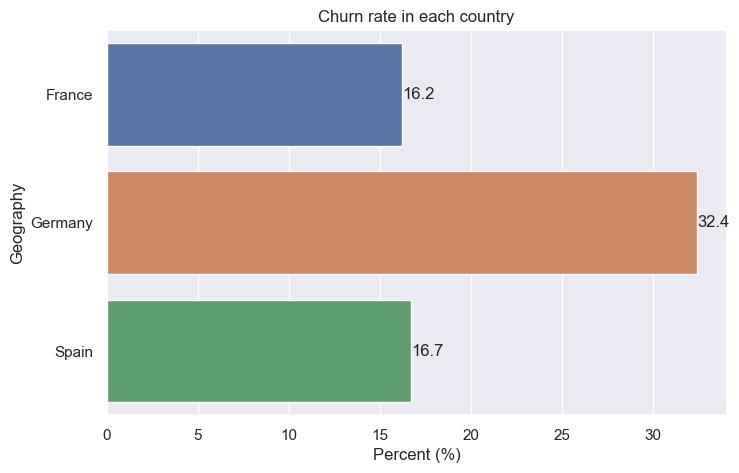

In [291]:
chart = sns.barplot(
    data=calc_percent_of_dataframe_columns(churned_customers, customer_data, 'Geography'), 
    x='Percent (%)', 
    y='Geography', 
    orient='h'
);
chart.set_title('Churn rate in each country')
show_bar_values(chart)
plt.show()

Abaixo também é possível observar que independente do país, as mulheres lideram os casos de churn.

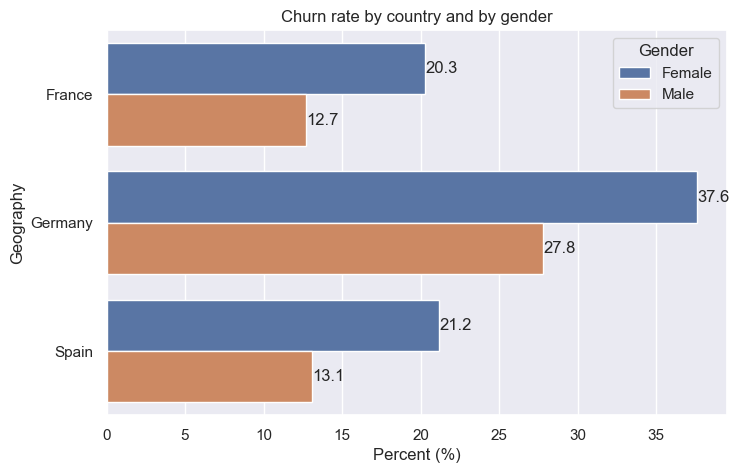

In [292]:
chart = sns.barplot(
    data=calc_percent_of_dataframe_columns(churned_customers, customer_data, ['Geography', 'Gender']), 
    x='Percent (%)', 
    y='Geography', 
    hue='Gender'
);
chart.set_title('Churn rate by country and by gender')
show_bar_values(chart)
plt.show()

E que os clientes que não possuem conta ativa são os mais prováveis.

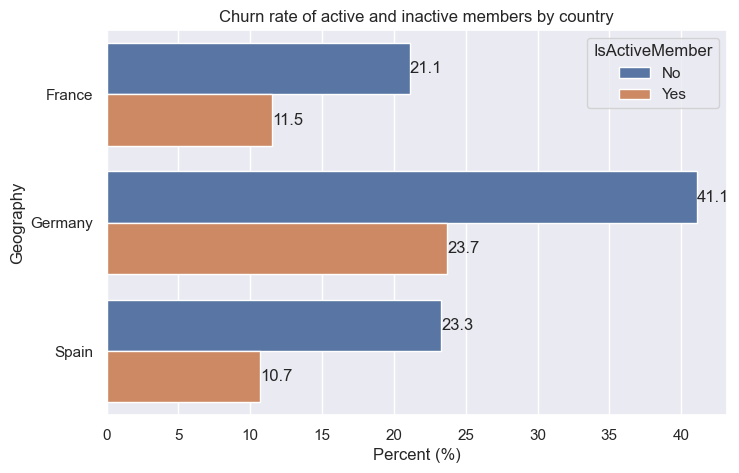

In [293]:
chart = sns.barplot(
    data=calc_percent_of_dataframe_columns(churned_customers, customer_data, ['Geography', 'IsActiveMember']), 
    x='Percent (%)', 
    y='Geography', 
    hue='IsActiveMember'
);
chart.set_title('Churn rate of active and inactive members by country')
show_bar_values(chart)
plt.show()

Olhando agora para o número de produtos é possível notar uma taxa elevada de churn entre os clientes que possuem de 3 a 4 produtos, <br>
sendo que 100% dos clientes que possuiam 4 produtos deram churn. 

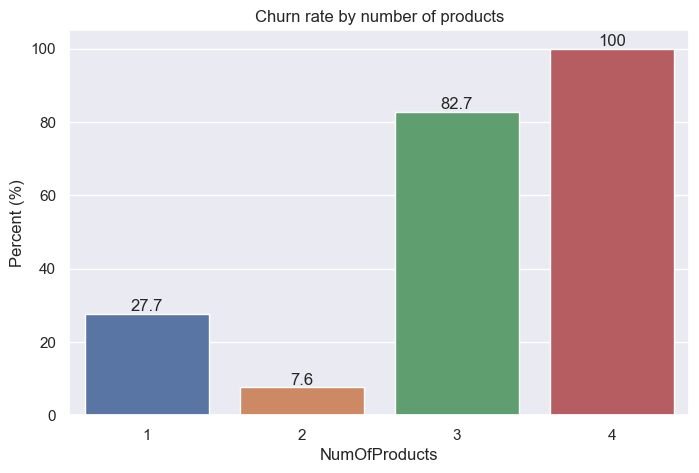

In [294]:
chart = sns.barplot(
    data=calc_percent_of_dataframe_columns(churned_customers, customer_data, 'NumOfProducts'), 
    x='NumOfProducts', 
    y='Percent (%)'
);
chart.set_title('Churn rate by number of products')
show_bar_values(chart)
plt.show()

Na tentativa de identificar uma propensão de churns relacionada ao fato do cliente possuir ou não cartão de crédito, <br> 
os percentuais se mostraram muito próximos não evidenciando qualquer tipo de relação.

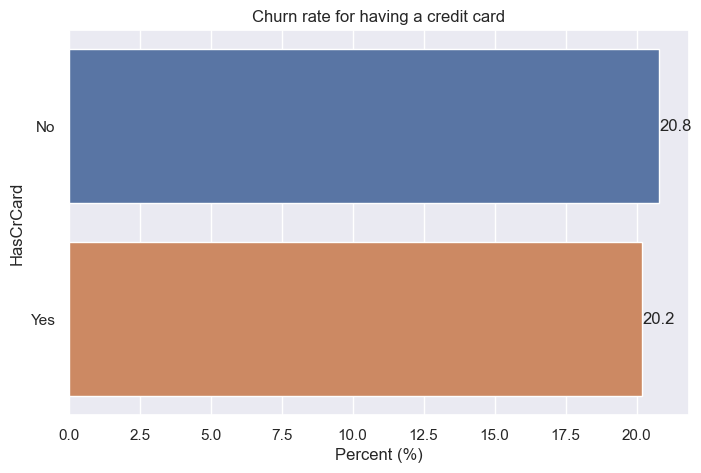

In [295]:
chart = sns.barplot(
    data=calc_percent_of_dataframe_columns(churned_customers, customer_data, 'HasCrCard'), 
    x='Percent (%)', 
    y='HasCrCard'
);
chart.set_title('Churn rate for having a credit card')
show_bar_values(chart)
plt.show()

Seguindo para análise das idades, é constatado que a faixa etária entre 50 a 60 anos é mais provável de dar churn, visto que cerca de 56.2% dos clientes o fizeram.

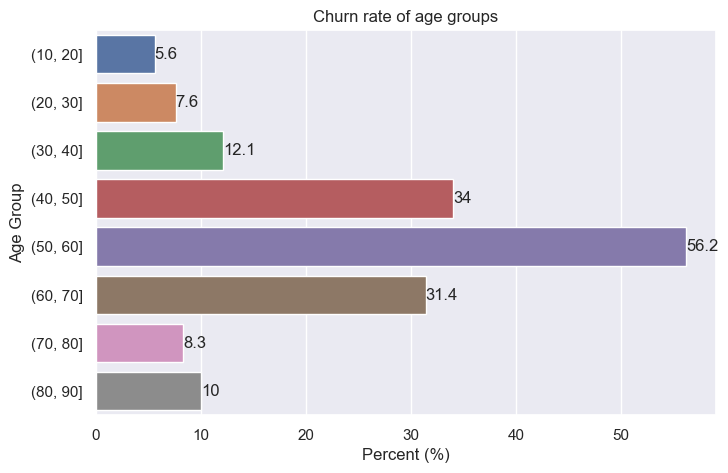

In [296]:
chart = sns.barplot(
    data=calc_percent_of_dataframe_columns(
        churned_customers, 
        customer_data, 
        'Age Group'
    ), 
    x='Percent (%)', 
    y='Age Group'
);
chart.set_title('Churn rate of age groups')
show_bar_values(chart)
plt.show()

Dos clientes entre 40 e 50 anos somente 34% deram churn. Mesmo essa faixa possuindo o maior número de clientes que deram churn.

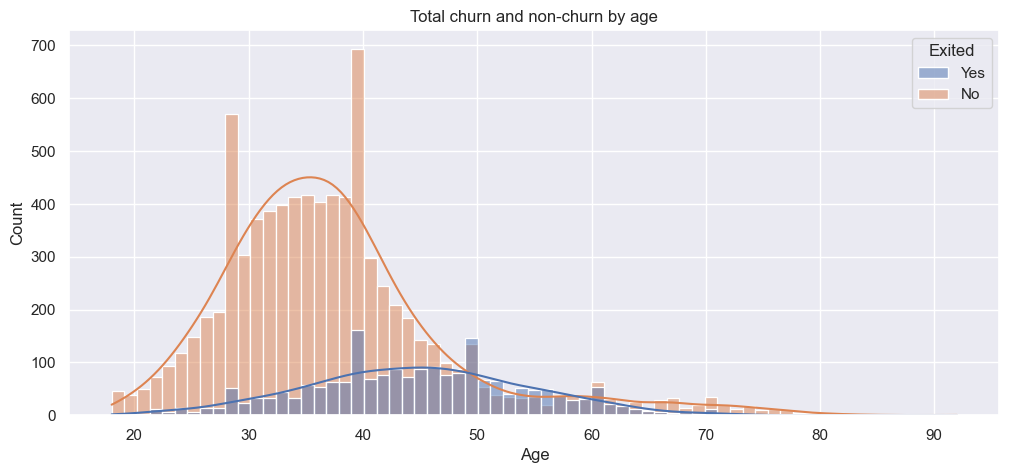

In [301]:
plt.figure(figsize=(12, 5))
chart = sns.histplot(data=customer_data, x='Age', hue='Exited', kde=True);
chart.set_title('Total churn and non-churn by age')
plt.show()

No que se refere a pontução de crédito, 100% os clientes que possuem pontuação de crédito entre 350 e 400 pontos derão churn.  
Porém são apenas 19 clientes que estão dentro dessa faixa. 

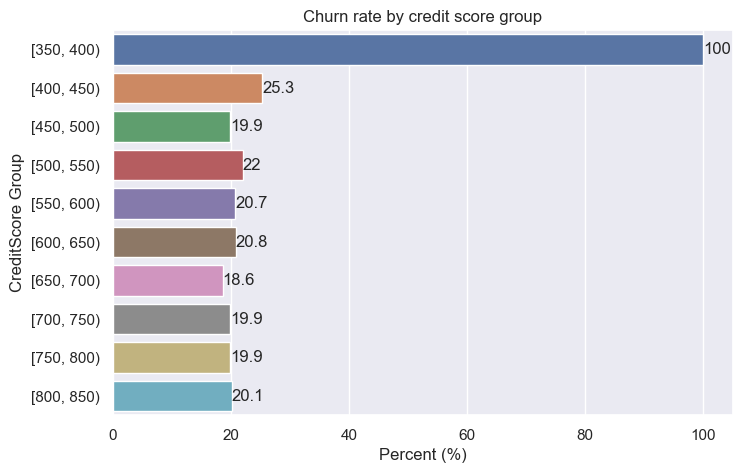

In [303]:
chart = sns.barplot(
    data=calc_percent_of_dataframe_columns(churned_customers, customer_data, 'CreditScore Group'),
    x='Percent (%)', 
    y='CreditScore Group'
)
chart.set_title('Churn rate by credit score group')
show_bar_values(chart)
plt.show()

Por outro lado, por volta de 92.5% dos clientes que deram churn possuem pontuação de crédito maior que 500.

In [299]:
churns_with_over_500_points = len(churned_customers[churned_customers['CreditScore'] > 500])
print(f'Percentual de churns acima de 500 pontos: {churns_with_over_500_points / TOTAL_CHURNS:.1%}')

Percentual de churns acima de 500 pontos: 92.5%


Já com relação ao saldo bancário, mais da metade dos clientes que possuem saldo maior que 200 mil sairam.

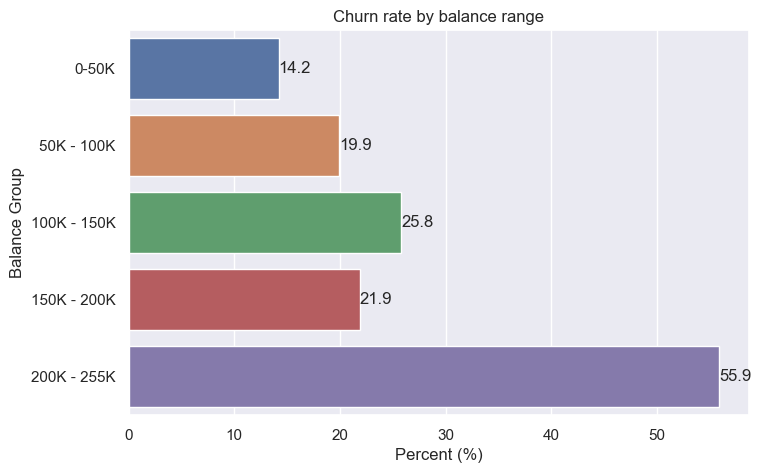

In [300]:
chart = sns.barplot(
    data=calc_percent_of_dataframe_columns(
        churned_customers, 
        customer_data, 
        'Balance Group'
    ), 
    x='Percent (%)', 
    y='Balance Group'
);
chart.set_title('Churn rate by balance range')
show_bar_values(chart)
plt.show()

## Conclusão

Perfil mais provável para churn: 
- Feminino
- Germânico
- Entre 40 e 60 anos
- Baixo risco de inadimplência (Pontuaçao de crédito alta)
- Saldo acima de 100 mil
- Mais de 2 produtos assinados

Necessário entender junto ao negócio quais são os tipos de produtos oferecidos e as métricas utilizadas para definir os indicadores de estabilidade no emprego e salário estimado.